In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input, SimpleRNN
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from sklearn import metrics

# Loading the dataset and data preparation
Dataset includes a lot of weather data and some other data, but for I'm going to use only min and max temperatures, precipitation and amount of customers.
Ofcourse we can't now weather from future, but it could possibly be weather forecast

In [2]:
df = pd.read_csv("bike_sharing_dataset.csv")
# Leave only needed columns
df = df[["total_cust", "date", "temp_min", "temp_max", "precip"]]
# Change data format to datetime
df["date"] = pd.to_datetime(df.date)
# Sort the dataset by date, reset the index
df = df.sort_values(by='date')
df = df.reset_index(drop=True)
# Define target variable for later usage
target = "total_cust"
# There are 4 missing values in target variable, to be faster just drop them
df = df.dropna()
df


,total_cust,date,temp_min,temp_max,precip
0,959.0,2011-01-01,-1.566667,11.973333,0.069333
1,781.0,2011-01-02,0.880000,13.806667,1.037349
2,1301.0,2011-01-03,-3.442857,7.464286,1.878824
3,1536.0,2011-01-04,-5.957143,4.642857,0.000000
4,1571.0,2011-01-05,-4.293333,6.113333,0.000000
...,...,...,...,...,...
2917,5430.0,2018-12-27,-3.591667,9.125000,0.024096
2918,2125.0,2018-12-28,0.608333,11.208333,16.843820
2919,6008.0,2018-12-29,3.925000,12.416667,11.550575
2920,4929.0,2018-12-30,0.816667,11.066667,0.104651


In [3]:
# Test dataset for future predictions
# Save only features without a target variable, last 120 points
test_df = df.drop(["total_cust", "date"], axis=1).iloc[-120:]
# Also save the original target values to compare with "future"
test_df_target = df["total_cust"].iloc[-120:]
# Change df to numpy array for future plots
test_df_target = test_df_target.to_numpy()
# Delete same rows from original DF to exclude data leakage
df = df.iloc[:-120]

Check if there are some dates missing

Only one gap with 5 days, I guess we can work with it

In [4]:
df['Gap'] = df['date'].diff().dt.days
missing_rows = df[df['Gap'] > 1]
print(missing_rows[['date', 'Gap']])

           date  Gap
1852 2016-01-27  5.0


C:\Users\kiril\AppData\Local\Temp\ipykernel_8184\4022421773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gap'] = df['date'].diff().dt.days


Let's see how seasonal the data is and what is a pattern

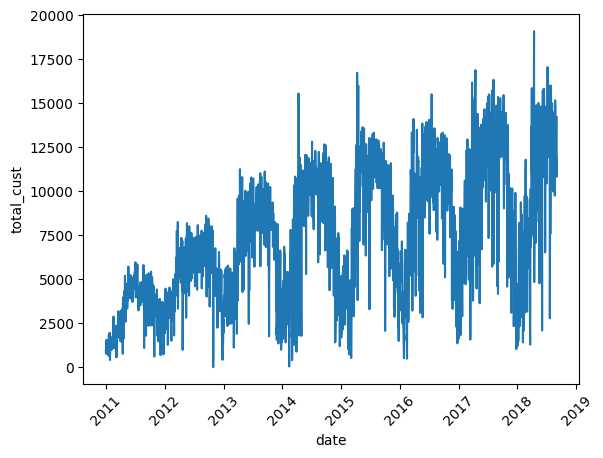

In [5]:
ax = sns.lineplot(data=df, x='date', y='total_cust')
# Show only year ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.show()

Data is clearly seasonal, amount of customers grows starting at spring, highest peak is during the summer and then it goes slowly down during autumn with lowest on winter.
It also has a clear growing trend

In [6]:
# Don't need date and gap anymore
df = df.drop(["date", "Gap"], axis=1)

## Scaling

In [7]:
# 67% for training, 33% for testing
cutoff = int(len(df) * 0.67)

X = df[:cutoff]
y = df[cutoff:]


## X/y Split

In [8]:
# Scale target variable
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
y = scaler.transform(y)

In [9]:
look_back = 60
# Function that generates time series chunks
def X_y_split(dataset, look_back):
    # Initialize variables
    dataX = []
    dataY = []
    for i in range(look_back, len(dataset)):
        # Append row by row into the list
        dataX.append(dataset[i - look_back:i, 0:dataset.shape[1]])
        dataY.append(dataset[i,0])
        # Return numpy array with lists
    return np.array(dataX), np.array(dataY)


X_train, y_train = X_y_split(X, look_back)
X_test, y_test = X_y_split(y, look_back)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1814, 60, 4)
(864, 60, 4)
(1814,)
(864,)


# LSTM

## Model initialisation

In [11]:
lstm = Sequential()
lstm.add(Input((look_back, df.shape[1])))
lstm.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
lstm.add(LSTM(100, recurrent_dropout=0.4))
lstm.add(Dense(4))
lstm.add(Dense(2))
lstm.add(Dense(1))
optimizer = optimizers.AdamW()
lstm.compile(optimizer=optimizer, loss='mse')

## Model training

In [12]:
# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_lstm.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

lstm.fit(X_train, y_train, epochs=150, verbose=1, validation_data=(X_test, y_test), callbacks=callback_list)

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0398 - val_loss: 0.0249
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0105 - val_loss: 0.0218
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0102 - val_loss: 0.0244
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0097 - val_loss: 0.0242
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0102 - val_loss: 0.0216
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0100 - val_loss: 0.0210
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0099 - val_loss: 0.0209
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0098 - val_loss: 0.0214
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0094 - val_loss: 0.0209
Epoch 10/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0096 - val_loss: 0.0209
Epoch 11/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0087 - val_loss: 0.0218
Epoch 12/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

## Evaluation

<Axes: >

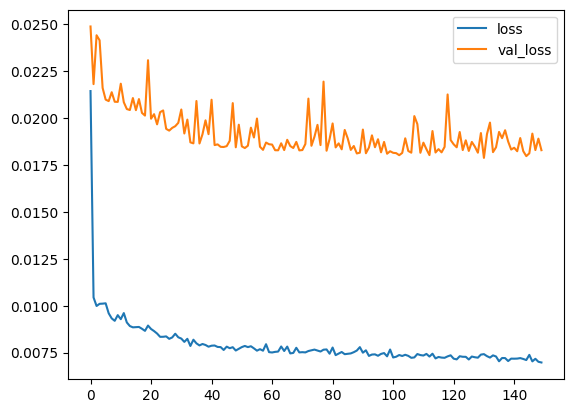

In [13]:
 # the usual training metric visualization
loss_df_lstm = pd.DataFrame(lstm.history.history)
loss_df_lstm.plot()

There is no points in training after 100 epochs, it's overfitting quite easily. No matter how a play around the model I couldn't get the loss and validation loss closer to each other. 

In [14]:
 # reload the best version of the model
lstm = load_model("best_model_lstm.keras")

In [15]:
test_predictions = lstm.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [16]:
# Transform original values back to unscaled version
original_copies_array = np.repeat(y_test, df.shape[1], axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(y_test), df.shape[1])))[:,0]

# Do the same for predictions
prediction_copies_array = np.repeat(test_predictions, df.shape[1], axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(test_predictions), df.shape[1])))[:,0]

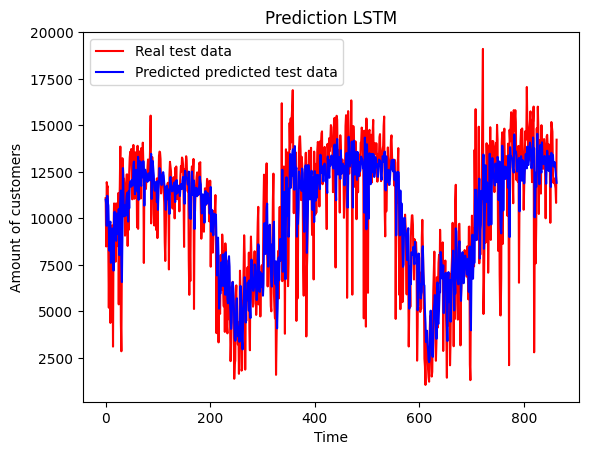

In [17]:
# Plot predicted VS real
plt.plot(original, color = 'red', label = 'Real test data')
plt.plot(pred, color = 'blue', label = 'Predicted predicted test data')
plt.title('Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('Amount of customers')
plt.legend()
plt.show()

## Metrics

In [18]:
errors = np.abs(original - pred)
mape = np.mean(errors / original) * 100

In [19]:
# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

print("\nMAE")
print(round(metrics.mean_absolute_error(original, pred), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(original, pred), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(original, pred)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(original, pred), 2))

MAPE (mean average precision error):
24.19 %

MAE
1620.33 units

MSE
5002213.5 units^2

RMSE:
2236.56 units

R-squared:
0.61


Working pretty well on the familiar data. May be not the best when it comes to the peaks, but can follow general pattern and can clearly see seasonal patterns

## Unknown futute

In [20]:
# Load last 30 days of dataset (our look back)
df_look_back = df.iloc[-look_back:]
df_look_back

,total_cust,temp_min,temp_max,precip
2742,14224.0,24.441667,32.575000,0.050526
2743,14305.0,24.353846,31.391667,1.143750
2744,17066.0,17.725000,27.945455,0.319149
2745,14947.0,14.166667,27.118182,0.000000
2746,14306.0,14.075000,29.125000,0.000000
2747,13539.0,16.858333,32.091667,0.000000
2748,14334.0,21.338462,32.850000,0.000000
2749,14896.0,19.876923,31.483333,0.000000
2750,15250.0,18.584615,30.608333,0.000000
2751,15755.0,17.916667,31.054545,0.000000


In [21]:
# Load features from the last 120 days of unseen testing dataset
df_120_days_future = test_df
df_120_days_future

,temp_min,temp_max,precip
2802,22.707692,32.269231,0.026087
2803,23.475000,33.683333,0.478571
2804,22.933333,33.650000,1.358000
2805,23.115385,33.653846,0.106000
2806,22.166667,32.000000,4.107921
...,...,...,...
2917,-3.591667,9.125000,0.024096
2918,0.608333,11.208333,16.843820
2919,3.925000,12.416667,11.550575
2920,0.816667,11.066667,0.104651


In [22]:
# We need to scale and merge two datasets
# First of all create target variable with only 0 in "future" data
df_120_days_future["total_cust"] = 0
# Rearrange columns in right way
df_120_days_future = df_120_days_future[["total_cust", "temp_min", "temp_max", "precip"]]
# Scale
old_scaled_array = scaler.transform(df_look_back)
new_scaled_array = scaler.transform(df_120_days_future)
# Reformat into dataframe for easy merge
new_scaled_df = pd.DataFrame(new_scaled_array)
# Change target of future data to nans
new_scaled_df.iloc[:,0] = np.nan
# merge datasets
full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df

,0,1,2,3
0,0.849208,0.959153,0.884901,0.000425
1,0.854051,0.957120,0.859081,0.009628
2,1.019133,0.803675,0.783885,0.002687
3,0.892436,0.721306,0.765834,0.000000
4,0.854111,0.719184,0.809623,0.000000
...,...,...,...,...
175,NaN,0.310233,0.373227,0.000203
176,NaN,0.407456,0.418685,0.141795
177,NaN,0.484230,0.445051,0.097235
178,NaN,0.412278,0.415594,0.000881


In [23]:
# Convert back to numpy array 
full_df_scaled_array = full_df.to_numpy()

all_data = []
# Process in the same-ish way as in previous splitting function, but this time replace nan with prediction
for i in range(look_back, len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-look_back :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=lstm.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

In [24]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,4, axis=-1)
y_pred_future = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),4)))[:,0]


##  Uknown future prediction visualization

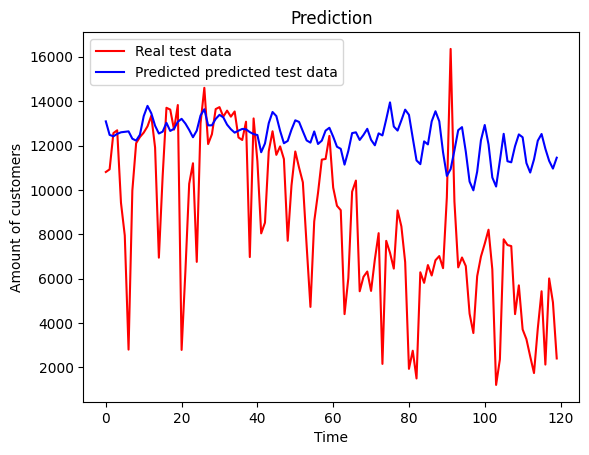

In [25]:
# Plot predicted VS real
plt.plot(test_df_target, color = 'red', label = 'Real test data')
plt.plot(y_pred_future, color = 'blue', label = 'Predicted predicted test data')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Amount of customers')
plt.legend()
plt.show()

Same problems on unseen data, at the very start it kind of understood general pattern, and even followed the downgoing trend, but model is not capable of recognizing turbo high and low peaks

## Test and thoughts

LSTM x2 100, dense 32, dropout 0.2

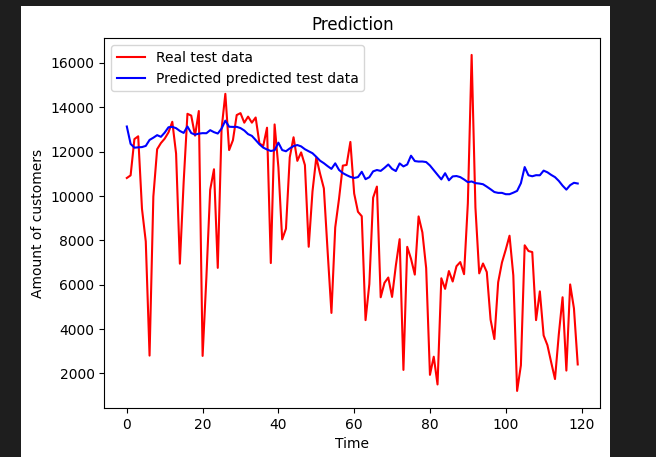

LSTM x2 100, dense 8, dropout 0.2

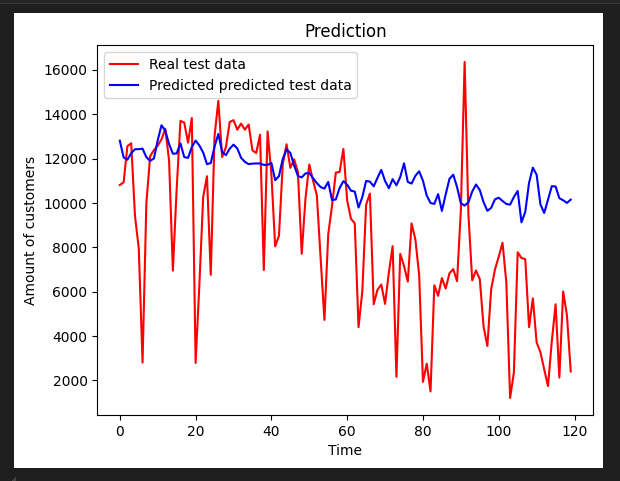

LSTM x2 100, dropout 0.2

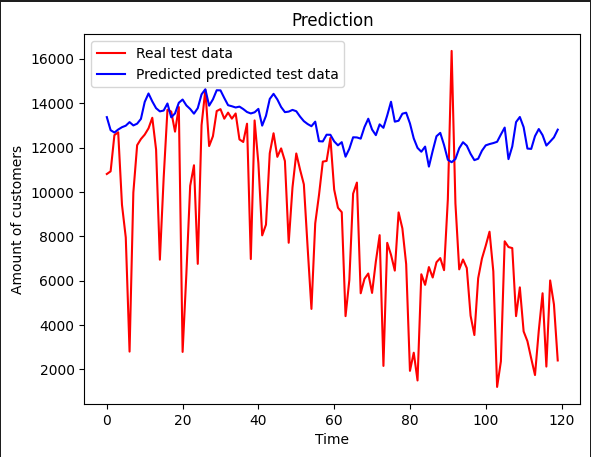

Looks like additional dense layer at least helps the model to catch the trend. On last screenshot, there were no dense layer and model just continued "random" fluctuactuion in straight direction, while with densen layers it follows the down trend.

Also dense layers might affect the fluctuactions' agressivness? 

Turns out thast in case if there are few LSTM layers, then they should have same amount of units. Otherwise model won't work properly and will be stacked on one same prediction.

Lower amount of units in LSTM constantly undershoots. On the other hand increasing amount of units over 100, LSTM layers over two, or increasing look back doesn't help that much. Also I've discovered that usual Dropout layer could bring too much noise into the memory of LSTM and instead it is recommended to use recurrent dropout. 

https://stackoverflow.com/a/58868383

2x 100 units LSTM, Dropout on second LSTM 0.4, Dense four nodes.

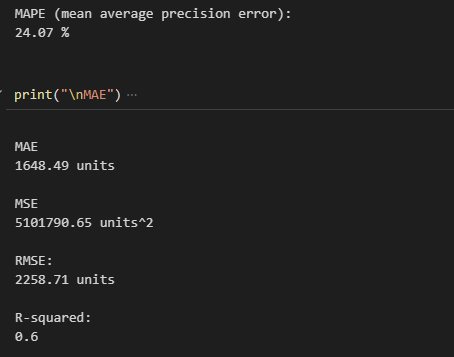


2x100 LSTM, Dropouts 0.2, 0.4; Additional Dense layer. RMSprop optimizer. Probably the best trend catcher for now, but the metrics are the same and model can't recognize spikes and shyly predicts closer to average 

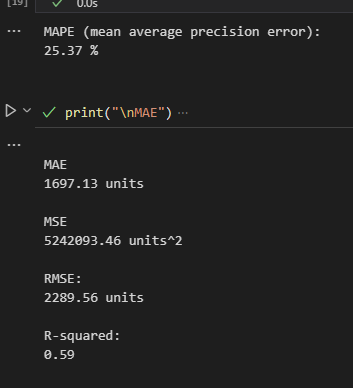
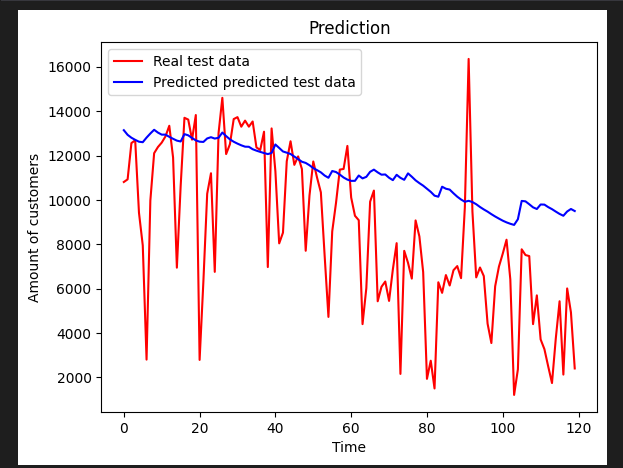

Same result with applying decay rate to optimizer. "Softness" of predictions might be caused by dense layers, let's try to just leave one.

Otherwise same setup, but slower decay rate and no dense layers. Previous one was better, so I'll try to move to other side and increase amount of dense nodes.

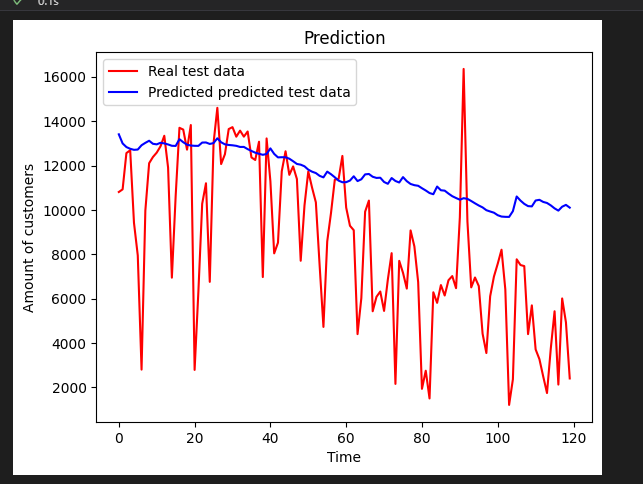

However, increasing amount of layers or nodes didn't changed the thing that much as I thought it could be, so I tried to change the optimizer (to AdamW) and tadaaam:

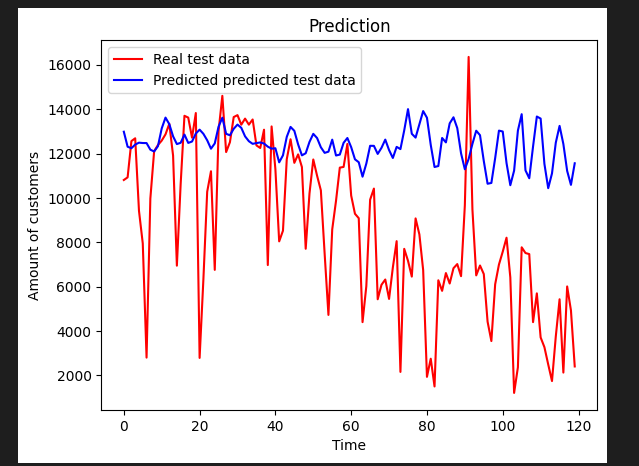
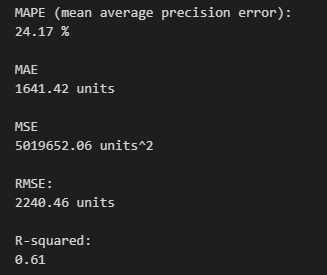

Now the model is more aggresive and even somehow can recognize peaks at the start, but in further future it is completly lost.

# RNN

In [56]:
look_back = 10

In [57]:
rnn = Sequential()
rnn.add(Input((look_back, df.shape[1])))
rnn.add(SimpleRNN(100, return_sequences=True, recurrent_dropout=0.2))
rnn.add(SimpleRNN(100, recurrent_dropout=0.4))
rnn.add(Dense(4))
rnn.add(Dense(2))
rnn.add(Dense(1))
optimizer = optimizers.AdamW()
rnn.compile(optimizer=optimizer, loss='mse')

In [58]:
# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_rnn.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

rnn.fit(X_train, y_train, epochs=300, verbose=1, validation_data=(X_test, y_test), callbacks=callback_list)

Epoch 1/300


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.0247 - val_loss: 0.0288
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2130 - val_loss: 0.0281
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1512 - val_loss: 0.0773
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1090 - val_loss: 0.0294
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0895 - val_loss: 0.0270
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0709 - val_loss: 0.0245
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0584 - val_loss: 0.0222
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0551 - val_loss: 0.0308
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0477 - val_loss: 0.0276
Epoch 10/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0447 - val_loss: 0.0242
Epoch 11/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0431 - val_loss: 0.0446
Epoch 12/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

<Axes: >

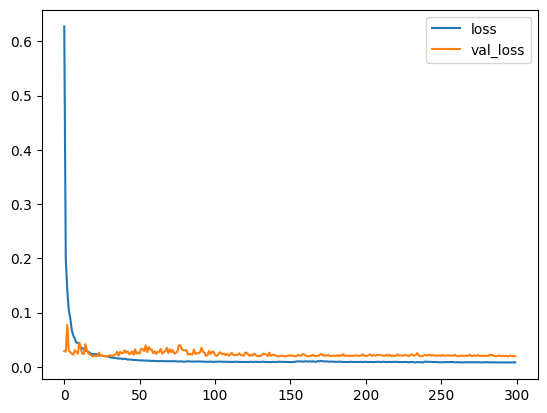

In [59]:
 # the usual training metric visualization
loss_df_rnn = pd.DataFrame(rnn.history.history)
loss_df_rnn.plot()

In [60]:
 # reload the best version of the model
rnn = load_model("best_model_rnn.keras")

In [61]:
test_predictions = rnn.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [62]:
# Transform original values back to unscaled version
original_copies_array = np.repeat(y_test, df.shape[1], axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(y_test), df.shape[1])))[:,0]

# Do the same for predictions
prediction_copies_array = np.repeat(test_predictions, df.shape[1], axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(test_predictions), df.shape[1])))[:,0]

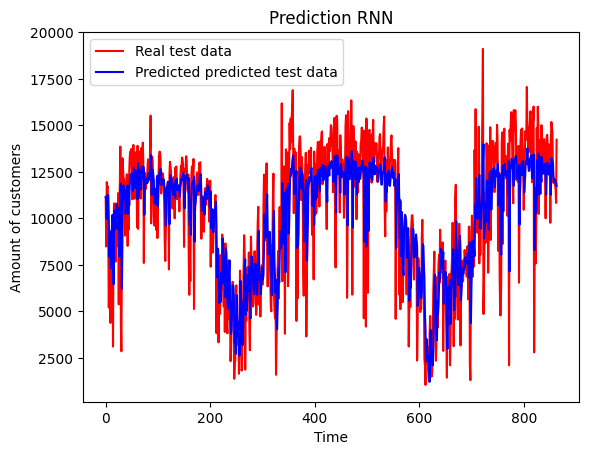

In [63]:
# Plot predicted VS real
plt.plot(original, color = 'red', label = 'Real test data')
plt.plot(pred, color = 'blue', label = 'Predicted predicted test data')
plt.title('Prediction RNN')
plt.xlabel('Time')
plt.ylabel('Amount of customers')
plt.legend()
plt.show()

In [64]:
errors = np.abs(original - pred)
mape = np.mean(errors / original) * 100

In [65]:
# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

print("\nMAE")
print(round(metrics.mean_absolute_error(original, pred), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(original, pred), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(original, pred)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(original, pred), 2))

MAPE (mean average precision error):
25.29 %

MAE
1707.93 units

MSE
5318525.81 units^2

RMSE:
2306.19 units

R-squared:
0.59


In [66]:
all_data = []
# Process in the same-ish way as in previous splitting function, but this time replace nan with prediction
for i in range(look_back, len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-look_back :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=rnn.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [67]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1, 1)
prediction_copies_array = np.repeat(new_array, 4, axis=-1)
y_pred_future = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(new_array), 4)))[:,0]

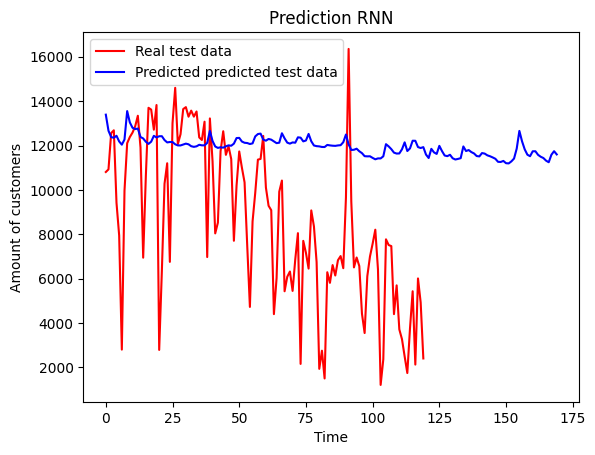

In [68]:
# Plot predicted VS real
plt.plot(test_df_target, color = 'red', label = 'Real test data')
plt.plot(y_pred_future, color = 'blue', label = 'Predicted predicted test data')
plt.title('Prediction RNN')
plt.xlabel('Time')
plt.ylabel('Amount of customers')
plt.legend()
plt.show()

Decreasing look back didn't help, RNN has too short memory. May be grouping by weeks could help, but it's easier to use LSTM, I guess.

# Prophet

Let's try to implement something similar with FB Prophet

In [70]:
from prophet import Prophet
from prophet.plot import plot_plotly

## Load the data again

In [71]:
df = pd.read_csv("bike_sharing_dataset.csv")
# Leave only needed columns
df = df[["total_cust", "date", "temp_min", "temp_max", "precip"]]
# Change data format to datetime
df["date"] = pd.to_datetime(df.date)
# Sort the dataset by date, reset the index
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

In [72]:
# Prophet requires columns y(target) and ds (time deimension)
prophet_new_names = {
    "date": "ds",
    "total_cust": "y"
}
df = df.rename(prophet_new_names, axis=1)

In [73]:
# Prophet init
m = Prophet()
# Add holidays
m.add_country_holidays(country_name='US')
# Train model
m.fit(df)

13:41:15 - cmdstanpy - INFO - Chain [1] start processing
13:41:15 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
# Looks like holidays that are "observed" are the one affecting the predictions.
m.train_holiday_names 

0                  New Year's Day
1                    Memorial Day
2                Independence Day
3                       Labor Day
4                    Veterans Day
5                Thanksgiving Day
6                   Christmas Day
7        Christmas Day (observed)
8      Martin Luther King Jr. Day
9           Washington's Birthday
10                   Columbus Day
11      New Year's Day (observed)
12        Veterans Day (observed)
13    Independence Day (observed)
dtype: object

In [75]:
# Create the dataset for future and extrapolation
future = m.make_future_dataframe(periods=120)
# Make a forecast
forecast = m.predict(future)


In [76]:
plot_plotly(m, forecast)

In FB Prophet I like the fact that everything is made very easy. Fitting is fast and you don't need to build a model by yourslef. Extrapolation is done by two code lines - creating the "future" dataset and filling it with predictions. Interactive plot is done just with one line.

And even counting the fact that I spended less than 15 minutes and there is zero optimizations, Prophet was able to catch the future trend and is going to right direction, while LSTM seemed to be strugling with that and needed a bit of work

However, I believe that Prophet's customization and further optimization might be quite hard. Sure, there are some built-in methods, but will they be enough?
